In [1]:
import pandas as pd
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn

# Import TensofFlow and check GPU support

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load and tokenize data

In [5]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import DistilBertTokenizer

# load dataset
ds = pd.read_parquet('/content/drive/MyDrive/ZHAW/fake_news/trials_tobi/news_cleaned_truncated_small_68k_samples_no_tokenization.parquet.gzip')

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
tokenized_data = ds['content'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Create labels

In [6]:
# Create a dictionary to map text labels to integers
unique_labels = ds['type'].unique()
label_dict = {label: i for i, label in enumerate(unique_labels)}

In [7]:
ds.head()

,type,content
2125946,bias,france implement obligations mistral ship buil...
5521778,bias,law fundraising hamas front group
4259721,bias,coup united states congress declared economic ...
3017370,bias,swedish aid worker anders suspended position o...
3360264,bias,judicial watch heels latest democratic scandal...


In [8]:
tokenized_data.head()

2125946    [101, 2605, 10408, 14422, 11094, 7941, 2911, 2...
5521778           [101, 2375, 15524, 22129, 2392, 2177, 102]
4259721    [101, 8648, 2142, 2163, 3519, 4161, 3171, 2162...
3017370    [101, 4467, 4681, 7309, 15387, 6731, 2597, 243...
3360264    [101, 8268, 3422, 8265, 6745, 3537, 9446, 4851...
Name: content, dtype: object

# Prepare dataset for training

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization and padding
max_length = 128  # Define the maximum length for padding/truncating
input_ids = pad_sequences(tokenized_data, maxlen=max_length, dtype="long", truncating="post", padding="post")

# Convert labels to numpy array
labels = np.array([label_dict[label] for label in ds['type']])

# Split data into training and validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)


In [10]:
labels

array([ 0,  0,  0, ..., 11, 11, 11])

# Define the model

In [11]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_dict))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

# Train the model - Not optimized

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
train_dataset = train_dataset.shuffle(len(train_inputs)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels))
val_dataset = val_dataset.batch(32)

# Start timing
start_time = time.time()

history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

# End timing
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"Training the model took {duration} seconds.")

1914/1914 [==============================] - 803s 419ms/step - loss: 1.0176 - accuracy: 0.6783 - val_loss: 0.9551 - val_accuracy: 0.7008
Training the model took 802.8889420032501 seconds.

# Optimization 1 - Larger batch size (128)

From Batch Size 32 to 64 and 128


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
train_dataset = train_dataset.shuffle(len(train_inputs)).batch(128)

val_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels))
val_dataset = val_dataset.batch(128)

# Start timing
start_time = time.time()

history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

# End timing
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"Training the model took {duration} seconds.")

In [ ]:
history = model.fit(train_dataset, epochs=12, validation_data=val_dataset)

# Optimization 2 - Use Prefetching and Parallel Data Loading

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
train_dataset = train_dataset.shuffle(len(train_inputs)).batch(128).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels))
val_dataset = val_dataset.batch(128).prefetch(AUTOTUNE)


history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)



Epoch 1/20
479/479 [==============================] - 260s 495ms/step - loss: 1.2832 - accuracy: 0.5920 - val_loss: 1.0019 - val_accuracy: 0.6836
Epoch 2/20
479/479 [==============================] - 236s 492ms/step - loss: 0.8725 - accuracy: 0.7240 - val_loss: 0.9625 - val_accuracy: 0.6936
Epoch 3/20
479/479 [==============================] - 236s 492ms/step - loss: 0.6664 - accuracy: 0.7869 - val_loss: 0.9555 - val_accuracy: 0.7029
Epoch 4/20
479/479 [==============================] - 236s 492ms/step - loss: 0.4785 - accuracy: 0.8466 - val_loss: 1.0351 - val_accuracy: 0.7017
Epoch 5/20
479/479 [==============================] - 236s 492ms/step - loss: 0.3136 - accuracy: 0.9018 - val_loss: 1.2256 - val_accuracy: 0.6964
Epoch 6/20
479/479 [==============================] - 236s 492ms/step - loss: 0.1965 - accuracy: 0.9379 - val_loss: 1.3470 - val_accuracy: 0.6919
Epoch 7/20
479/479 [==============================] - 236s 492ms/step - loss: 0.1259 - accuracy: 0.9604 - val_loss: 1.5333 -

# Predictions

In [ ]:
# Make predictions on the validation dataset
val_predictions = model.predict(val_dataset)
predicted_classes = np.argmax(val_predictions.logits, axis=1)

true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
reverse_label_dict = {i: label for label, i in label_dict.items()}
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Convert numeric labels in the confusion matrix to string labels
axis_labels = [reverse_label_dict[i] for i in range(len(label_dict))]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=axis_labels, yticklabels=axis_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Label Names')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()



# Evaluation

In [ ]:
results = model.evaluate(val_dataset)
print("Validation results:")
for metric, value in zip(model.metrics_names, results):
    print(f"{metric}: {value}")


# Saving and loading

In [ ]:
model.save('distilbert_prefetch_parallel_gpu', save_format='tf')

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('distilbert_prefetch_parallel_gpu')

# Performance Plot

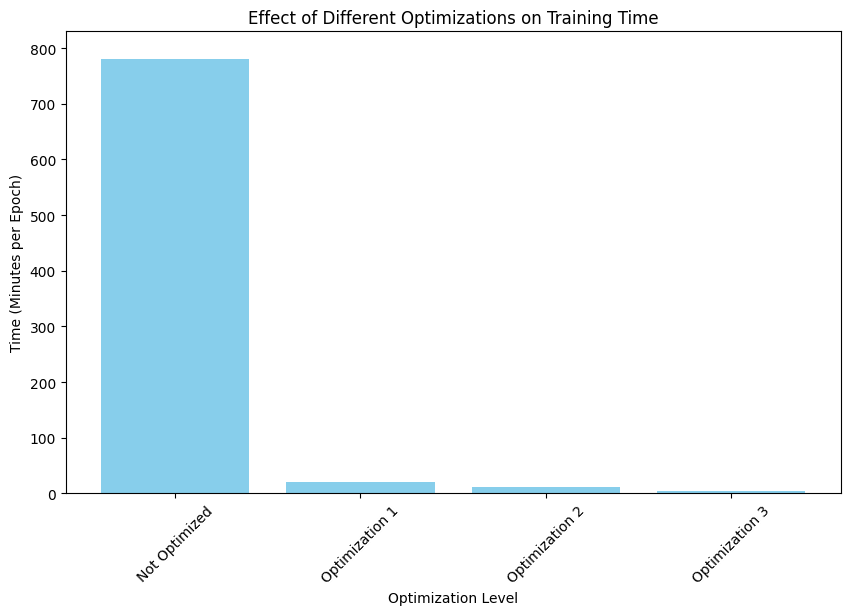

In [ ]:
import matplotlib.pyplot as plt

# Data
optimizations = ['Not Optimized', 'Optimization 1', 'Optimization 2', 'Optimization 3']
minutes_per_epoch = [780, 20, 12, 4]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(optimizations, minutes_per_epoch, color='skyblue')
plt.xlabel('Optimization Level')
plt.ylabel('Time (Minutes per Epoch)')
plt.title('Effect of Different Optimizations on Training Time')
plt.xticks(optimizations, rotation=45)
plt.ylim(0, max(minutes_per_epoch) + 50)  # Setting the y-axis limit a bit higher for clarity

# Show the plot
plt.show()
